# FDN Reverberator - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: 10557065, MATR: 953546 )

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import scipy as sp
import IPython.display as ipd

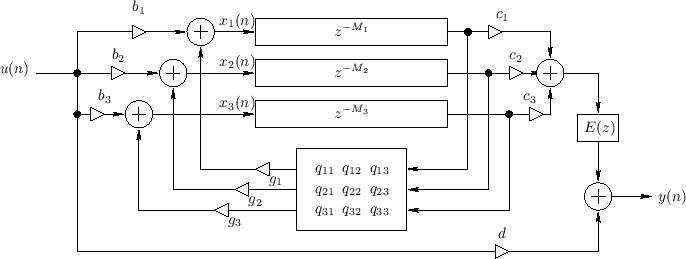

In [2]:
ipd.Image(filename = "images/FDNScheme.png")

## Params

In [75]:
fs = 22050
N = 4
g = np.ones(N) # cambia come vuoi

t60 = 1 # reverberation time
# TODO: reverberation time should be function of frequency! from 0 to fs/2
F_bands = 6
t60 = np.repeat(1.5, F_bands) #! constant, need to create a graphic 'eq' to select t60
t60 = [1, 1, 0.3]
print(t60) 

# Min delay lenght
# TODO: create slider to select length (starting from min)
M_min = int(np.ceil(0.15*np.max(t60)*fs))
print(M_min)

[1, 1, 0.3]
3308


In [76]:
primeN = []

for num in range(2,101):
    prime = True
    for i in range(2,num):
        if (num%i==0):
            prime = False
    if prime:
       primeN.append(num)

M = []
for i in primeN:
    m = np.floor(0.5+np.log(M_min)/np.log(i))
    if i**m>M_min:
        M.append(int(i**m))

M = np.sort(M)

M = M[:N]

print(M)
# TODO: select numbers according to min desired length

[3481 3721 4096 4489]


## Lossless Feedback Matrix

Hadamard Matrix

In [77]:
if((N & (N-1) == 0) and N != 0):
    Had = 1/np.sqrt(N)*sp.linalg.hadamard(N)
    print(Had)


[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]


Householder Matrix

In [78]:
u = np.ones(N)
Hous = np.identity(N)-2/N*u*u.T
print(Hous)

[[ 0.5 -0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5  0.5]]


## Delay IR

In [79]:
u = [1, 0, 0, 0]


D = np.zeros((N, M[-1]+len(u)))

for i in range(N):
    D[i, M[i]-1] = 1



In [41]:
#Circuit
#Parameter initialization
U = [1, 0, 0, 0]
B = [1,1,1]
C = [1,1,1]
G = [1,1,1]
A = Hous
'''                                          1 2 3 4
#Delay lines data structure initialization   _ _ _ _  list of vectors
                                             | | | |
                                             | | | |
'''
delay_lines=[]
delay_outputs=[]
for i in range(N):
    delay_lines.append(np.zeros(M[i]))


for u in U: # For every sample of the input
    for i in range(N): # For every circuit calculate output of delay lines and shift
        delay_outputs.append(delay_lines[i][-1])
        delay_lines[1:M[i]-1] = delay_lines[i][0:M[i]-2]
    
    delay_outputs_array=np.asanyarray(delay_outputs)
    delay_output_mixed = A*delay_outputs_array # calculate feedback with the selected mixing matrix

    Output = np.sum(np.multiply(delay_outputs_array, C)) # Calculate Output to E(z)

    for i in range(N):
        delay_lines[i][0] = B[i]*u + G[i] * delay_output_mixed[i] # insert the calculated input+feedback value into the first position of each delay line


0.0


IndexError: invalid index to scalar variable.

Once we have delayed the splitted signal, apply a filter (to each delay line). This filter is used to determine the $t_{60}$ of the reverb in each frequency band.

[0.33604277145703, 0.33604277145703, 0.02638245419196366]
0.048923929114646734 0.8544116009324644


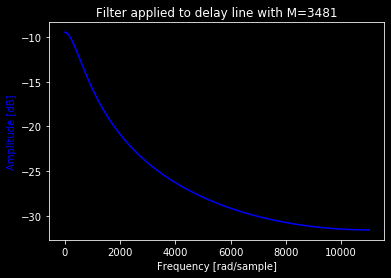

[0.31170336920701036, 0.31170336920701036, 0.020533910054306465]
0.03852962533976695 0.8763900902393568


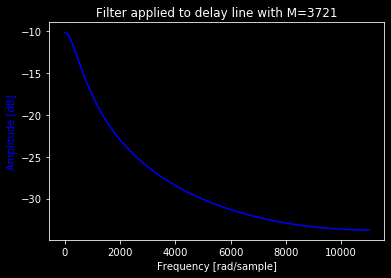

[0.27715396014362303, 0.27715396014362303, 0.01388045262318633]
0.02643689023939894 0.9046129803604497


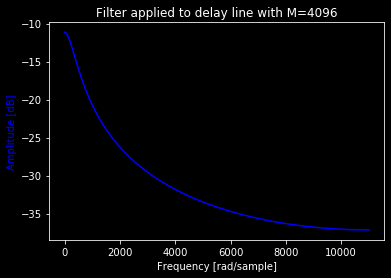

[0.24504830377994255, 0.24504830377994255, 0.009208148946242882]
0.017749333446887162 0.9275680215977894


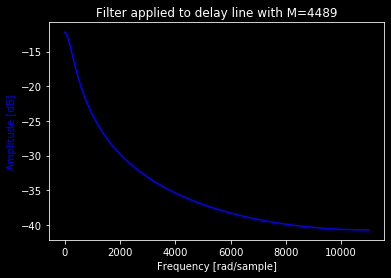

In [90]:
# Case 1: Simple 1st order filter

# we obtain one filter per signal!
for M_i in M:
    R_M = []
    # R_M = 1-(6.91*M_i/t60*fs)
    for t60_f in t60:
        R_M.append(10**((-3*M_i)/(t60_f*fs))) 
        
    print(R_M)

    # pole
    p_i = (R_M[0]-R_M[-1])/(R_M[0]+R_M[-1])

    # gain
    g_i = 2*(R_M[0]*R_M[-1])/(R_M[0]+R_M[-1])

    print(g_i, p_i)

    b = [0, g_i]
    a = [-p_i, 1]

    w, h = sp.signal.freqz(b,a, fs=fs)

    fig, ax1 = plt.subplots()
    ax1.set_title('Filter applied to delay line with M={}'.format(M_i))
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    # ax2 = ax1.twinx()
    # angles = np.unwrap(np.angle(h))
    # ax2.plot(w, angles, 'g')
    # ax2.set_ylabel('Angle (radians)', color='g')
    # ax2.grid()
    # ax2.axis('tight')
    plt.show()

In [49]:
# Case 2: Orthogonalized 1st order delay filter

for M_i in M:

    # gain
    g_i = 10**((-3*M_i)/(t60[0]*fs))

    # pole and zero
    p_i = np.log(10)/4 * np.log10(g_i) * (1-(1/(t60[-1]/t60[0])**2))

    print(g_i, p_i)


0.33604277145703 2.7565842119909933
0.31170336920701036 2.9466388545873277
0.27715396014362303 3.243599233644099
0.24504830377994255 3.5548137108955955


In [65]:
# Case 3: Multiband filter design (preferred)

for M_i in M:

    G_i = []
    # gain (one per band)
    for t60_f in t60:
        G_i.append(10**((-3*M_i)/(t60_f*fs))) 

    
    print(G_i)

[0.33604277145703, 0.2976951305764875, 0.2558545809928898, 0.2558545809928898, 0.1129247442485217, 0.02638245419196366]
[0.31170336920701036, 0.27383600596645863, 0.23290395890861185, 0.23290395890861185, 0.09715899037500181, 0.020533910054306465]
[0.27715396014362303, 0.2403262497249127, 0.20109504077280402, 0.20109504077280402, 0.07681431762329298, 0.01388045262318633]
[0.24504830377994255, 0.2095997587963373, 0.1724108630543861, 0.1724108630543861, 0.060048671185427005, 0.009208148946242882]


Spectral coloration equalizer

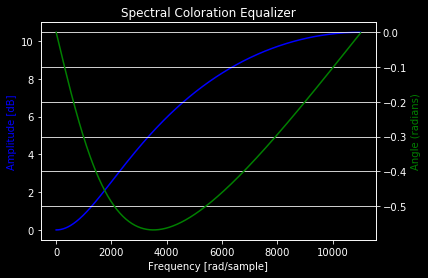

In [73]:
# coefficient of the filter:

b_coeff = (1-(t60[-1]/t60[0]))/(1+(t60[-1]/t60[0]))

b = [-b_coeff, 1]
a = [0, 1-b_coeff]

w, h = sp.signal.freqz(b,a, fs=fs)

fig, ax1 = plt.subplots()
ax1.set_title('Spectral Coloration Equalizer')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
# ax2 = ax1.twinx()
# angles = np.unwrap(np.angle(h))
# ax2.plot(w, angles, 'g')
# ax2.set_ylabel('Angle (radians)', color='g')
# ax2.grid()
# ax2.axis('tight')
plt.show()